In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
from typing import List, Tuple
import uproot3

In [2]:
ls ~/data/2D_recovery_studies/increased_covmatrix

all_2D/        s_0.4/  s_0.82/  s_0.92/  xyz_blowup/
higher_stats/  s_0.5/  s_0.84/  s_0.94/  xyz_seq_highstats_id/
s_0.1/         s_0.6/  s_0.86/  s_0.96/  xyz_seq_withId/
s_0.2/         s_0.7/  s_0.88/  s_0.98/  y_blowup/
s_0.3/         s_0.8/  s_0.9/   s_1/     z_blowup/


In [3]:
input_file = (
    str(pathlib.Path.home())
    + '/data/2D_recovery_studies/increased_covmatrix/xyz_seq_highstats_id/Lb2JPsiL_Run2_Sim_2016_MagUp_v12_with2D.root'
)

In [4]:
save_plots = True

## Pick what extra branches you want
with_dtf = True
with_pidsubs = False
with_protoparticles = False
with_2Ddebug = True
with_truevtx_kinematics = True

## Perform analysis with:
## - All data: 'b' (both)
## - Only Lambdas: 'm' (matter)
## - Only antiLambdas: 'a' (antimatter)
use_matter_antimatter = 'b'

## Choose colors
color_gen = 'tab:gray'
color_3D = 'tab:blue'
color_2D = 'tab:orange'

In [5]:
if use_matter_antimatter == 'b':
    event_category_label = 'All reconstructed events'
elif use_matter_antimatter == 'm':
    event_category_label = 'Only matter events'
elif use_matter_antimatter == 'a':
    event_category_label = 'Only antimatter events'
else:
    raise ValueError

In [6]:
## Create plots directory, if missing
plots_dir = (str(pathlib.Path.home())
                  + '/vertex-reconstruction-studies/'
                  + 'plots/'
                  + 'studies_on_integrated_root_files/'
                  + 'residuals_at_true_vertex_analysis/'
)
pathlib.Path(plots_dir).mkdir(parents=True, exist_ok=True)

# Import data (v1.2)

In [7]:
def root_file_to_df(
    filename: str,
    branchlist: List[str]
) -> pd.DataFrame:
    with uproot3.open(filename) as file_root:
        tree = file_root['Lb_T/DecayTree']
        ## Load dataFrame with desired branches
        #df = tree.pandas.df(branchlist, flatten=False)
        df = tree.pandas.df(branchlist).loc[(slice(None), 0), :]
        ## Reset indices
        df.reset_index(drop=True, inplace=True)
        return df

## Choose branches

In [8]:
composite_particles = ['Lb', 'L', 'Jpsi']
basic_particles = ['p', 'pim', 'mum', 'mup']
lambda_baryons = ['L', 'Lb']

lambdab_daughters = ['L', 'Jpsi']
lambdab_daughters_DTF = ['Lambda0', 'J_psi_1S']

lambdab_nephews = {
    'L': ['p', 'pim'],
    'Jpsi': ['mum', 'mup'],
}
lambdab_nephews_DTF = {
    'Lambda0': ['pplus', 'piplus'],
    'J_psi_1S': ['muminus_0', 'muminus'],
}

DTF_mass_constraints = ['FixJPsi', 'FixJPsiLambda']

### Original names

In [9]:
## Reco branches
reco_branches = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_ENDVERTEX_' + component)
    reco_branches.append(prefix + '_M')
    reco_branches.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_P' + component)
    reco_branches.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches.append(prefix + '_BPVDIRA')
    reco_branches.append(prefix + '_BPVIPCHI2')
    reco_branches.append(prefix + '_BPVVDCHI2')
    reco_branches.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches.append('Lb_OWNPV_' + feature)

reco_branches.append('Polarity')

## Truth branches
truth_branches = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEP_' + component)

truth_branches.append('L_TRUEID')
truth_branches.append('Lb_TRUEID')
        
for prefix in basic_particles + composite_particles:
    truth_branches.append(prefix + '_Reconstructible')
    truth_branches.append(prefix + '_Reconstructed')

## DTF branches
dtf_branches = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_status')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_M')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_P')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_chi2')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_M')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_P')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_' + daughter + '_P' + component)
                    
    pidsubs_branches.append('TrackType')

## Protoparticle branches
pp_branches = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches = []
if with_2Ddebug:
    debug_branches.append('L_ENDVERTEX_XERR')
    debug_branches.append('L_ENDVERTEX_YERR')
    debug_branches.append('L_ENDVERTEX_ZERR')
    debug_branches.append('L_ALGO_ID')
    
## True vertex kinematics
truevtxkin_branches = []
if with_truevtx_kinematics:
    for prefix in ['p', 'pim']:
        ## No z, it's fixed by the transporter
        for component in ['X', 'Y']:
            truevtxkin_branches.append(prefix + '_AtTrueVtx_REFP_' + component)
            truevtxkin_branches.append(prefix + '_AtTrueVtx_REFP_' + component + "ERR")
            
        for component in ['X', 'Y', 'Z']:
            truevtxkin_branches.append(prefix + '_AtTrueVtx_P_' + component)
            truevtxkin_branches.append(prefix + '_AtTrueVtx_P_' + component + "ERR")
    
branches = (
    reco_branches + truth_branches
    + dtf_branches + pp_branches
    + pidsubs_branches + debug_branches
    + truevtxkin_branches
)

### New names

In [10]:
## Reco branches
reco_branches_renamed = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_ENDVERTEX_' + component)
    reco_branches_renamed.append(prefix + '_M')
    reco_branches_renamed.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_P' + component)
    reco_branches_renamed.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches_renamed.append(prefix + '_BPVDIRA')
    reco_branches_renamed.append(prefix + '_BPVIPCHI2')
    reco_branches_renamed.append(prefix + '_BPVVDCHI2')
    reco_branches_renamed.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches_renamed.append('Lb_OWNPV_' + feature)

reco_branches_renamed.append('Polarity')

## Truth branches
truth_branches_renamed = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_ENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_P' + component)

truth_branches_renamed.append('MCTRUTH_L_ID')
truth_branches_renamed.append('MCTRUTH_Lb_ID')
        
for prefix in basic_particles + composite_particles:
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructible')
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructed')

## DTF branches
dtf_branches_renamed = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_status')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_M')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_P')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_chi2')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches_renamed.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters:
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches_renamed = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_M')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_P')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + daughter + '_P' + component)
                    
    pidsubs_branches_renamed.append('TrackType')

## Protoparticle branches
pp_branches_renamed = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches_renamed.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches_renamed.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches_renamed = []
if with_2Ddebug:
    debug_branches_renamed.append('L_ENDVERTEX_XERR')
    debug_branches_renamed.append('L_ENDVERTEX_YERR')
    debug_branches_renamed.append('L_ENDVERTEX_ZERR')
    debug_branches_renamed.append('L_ALGO_ID')

## True vertex kinematics
truevtxkin_branches_renamed = []
if with_truevtx_kinematics:
    for prefix in ['p', 'pim']:
        ## No z, it's fixed by the transporter
        for component in ['X', 'Y']:
            truevtxkin_branches_renamed.append(prefix + '_AtTrueVtx_REFP_' + component)
            truevtxkin_branches_renamed.append(prefix + '_AtTrueVtx_REFP_' + component + "ERR")
            
        for component in ['X', 'Y', 'Z']:
            truevtxkin_branches_renamed.append(prefix + '_AtTrueVtx_P_' + component)
            truevtxkin_branches_renamed.append(prefix + '_AtTrueVtx_P_' + component + "ERR")

branches_renamed = (
    reco_branches_renamed + truth_branches_renamed
    + dtf_branches_renamed + pp_branches_renamed
    + pidsubs_branches_renamed + debug_branches_renamed
    + truevtxkin_branches_renamed
)

In [11]:
if len(branches_renamed) != len(branches):
    raise ValueError("Number of columns before and after renaming does not match.")

## Import ROOT file

In [12]:
df_events = root_file_to_df(input_file, branches)

column_rename_dictionary = {}
for old_name, new_name in zip(branches, branches_renamed):
    column_rename_dictionary[old_name] = new_name
    
df_events.rename(columns=column_rename_dictionary, inplace=True)

## Replace `ALGO_ID` with intelligible labels

In [13]:
algo_id_dictionary = {
    -10: 'NonConverged',
     -1: 'Unspecified',
      0: 'VertexFitter',
      1: 'XBlownUpAlgorithm',
      2: 'YBlownUpAlgorithm',
      3: 'XYBlownUpAlgorithm',
      4: 'ZBlownUpAlgorithm',
      5: 'XZBlownUpAlgorithm',
      6: 'YZBlownUpAlgorithm',
      7: 'XYZBlownUpAlgorithm',
     10: 'Generic2DAlgorithm',
}

df_events.replace({'L_ALGO_ID': algo_id_dictionary}, inplace=True)

In [14]:
df_events

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,pim_AtTrueVtx_REFP_X,pim_AtTrueVtx_REFP_XERR,pim_AtTrueVtx_REFP_Y,pim_AtTrueVtx_REFP_YERR,pim_AtTrueVtx_P_X,pim_AtTrueVtx_P_XERR,pim_AtTrueVtx_P_Y,pim_AtTrueVtx_P_YERR,pim_AtTrueVtx_P_Z,pim_AtTrueVtx_P_ZERR
0,1.674753,0.053259,0.004623,5548.595304,5994.525949,461.983261,-78.247981,6504.222043,1098.518302,1116.608101,...,458.759346,0.511805,-78.574176,0.897767,606.252359,11.646095,-23.114742,4.174266,8898.281548,270.569333
1,0.880395,-0.130333,15.654301,4900.959051,5196.066164,209.545799,199.243538,4381.083975,1228.240710,1286.308889,...,553.301898,94.433061,151.678781,15.792875,-371.226753,50.603826,35.846464,6.626007,2933.749120,193.418693
2,0.893069,-0.210212,27.346294,5669.609293,5447.484208,84.953310,-116.199707,5557.096303,1196.546077,1204.210206,...,82.850734,2.769312,-105.195116,1.534713,164.982768,27.578850,-417.719612,28.084590,16298.743305,1049.126635
3,0.605714,-0.203049,22.148035,5645.205401,5601.574674,-202.498747,18.725639,3762.349599,1179.755864,1134.066434,...,-161.607356,13.781475,12.810695,2.998664,-608.700042,32.986100,93.965996,9.491493,11530.181615,821.754092
4,0.636031,-0.090822,-65.799311,5666.024183,5523.351851,-207.686722,152.674077,7297.794399,1142.059990,1140.502451,...,-206.284053,0.116203,151.615833,0.695767,-450.090259,22.448817,233.093595,14.199858,14260.014653,583.613758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,0.792793,-0.153357,-27.134301,5552.073384,5700.196864,-63.514990,5.060145,467.127720,1075.296644,1102.470790,...,-19.181646,80.784525,101.153709,8.616915,315.598522,132.781490,98.646025,8.933629,2906.069264,266.492572
2393,0.715787,-0.237929,-24.543360,5580.116199,5538.928843,-260.224385,121.363209,5265.321387,1082.767384,1090.171388,...,-248.378015,8.821240,113.169946,4.017728,-235.904593,65.129519,135.752038,12.252045,7194.163251,514.511984
2394,1.025268,-0.347555,110.111895,5563.561252,5484.832574,14.961722,-29.933930,2339.392177,1153.081028,1154.792714,...,15.125658,11.879711,-45.844570,2.418562,-28.439100,96.262451,-303.496826,27.427948,16813.406983,1450.596258
2395,0.555001,-0.282748,58.317676,-120555.108929,25778.611947,-297.812857,-92.954604,6092.902518,-3231.821376,1528.140408,...,-297.474224,1.971766,-92.469975,2.545755,-707.060904,106.406733,-184.781543,25.561651,16199.143577,1635.444655


# Apply further selections
## Select matter/antimatter

In [15]:
df_events['MCTRUTH_Lb_ID'].value_counts()

-5122    1204
 5122    1193
Name: MCTRUTH_Lb_ID, dtype: int64

In [16]:
if not use_matter_antimatter == 'b':
    if use_matter_antimatter == 'm':
        Lb_ID_constraint = 5122
    elif use_matter_antimatter == 'a':
        Lb_ID_constraint = -5122
    else:
        raise ValueError
    
    df_events = df_events.loc[df_events['MCTRUTH_Lb_ID'] == Lb_ID_constraint]

In [17]:
df_events

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,pim_AtTrueVtx_REFP_X,pim_AtTrueVtx_REFP_XERR,pim_AtTrueVtx_REFP_Y,pim_AtTrueVtx_REFP_YERR,pim_AtTrueVtx_P_X,pim_AtTrueVtx_P_XERR,pim_AtTrueVtx_P_Y,pim_AtTrueVtx_P_YERR,pim_AtTrueVtx_P_Z,pim_AtTrueVtx_P_ZERR
0,1.674753,0.053259,0.004623,5548.595304,5994.525949,461.983261,-78.247981,6504.222043,1098.518302,1116.608101,...,458.759346,0.511805,-78.574176,0.897767,606.252359,11.646095,-23.114742,4.174266,8898.281548,270.569333
1,0.880395,-0.130333,15.654301,4900.959051,5196.066164,209.545799,199.243538,4381.083975,1228.240710,1286.308889,...,553.301898,94.433061,151.678781,15.792875,-371.226753,50.603826,35.846464,6.626007,2933.749120,193.418693
2,0.893069,-0.210212,27.346294,5669.609293,5447.484208,84.953310,-116.199707,5557.096303,1196.546077,1204.210206,...,82.850734,2.769312,-105.195116,1.534713,164.982768,27.578850,-417.719612,28.084590,16298.743305,1049.126635
3,0.605714,-0.203049,22.148035,5645.205401,5601.574674,-202.498747,18.725639,3762.349599,1179.755864,1134.066434,...,-161.607356,13.781475,12.810695,2.998664,-608.700042,32.986100,93.965996,9.491493,11530.181615,821.754092
4,0.636031,-0.090822,-65.799311,5666.024183,5523.351851,-207.686722,152.674077,7297.794399,1142.059990,1140.502451,...,-206.284053,0.116203,151.615833,0.695767,-450.090259,22.448817,233.093595,14.199858,14260.014653,583.613758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,0.792793,-0.153357,-27.134301,5552.073384,5700.196864,-63.514990,5.060145,467.127720,1075.296644,1102.470790,...,-19.181646,80.784525,101.153709,8.616915,315.598522,132.781490,98.646025,8.933629,2906.069264,266.492572
2393,0.715787,-0.237929,-24.543360,5580.116199,5538.928843,-260.224385,121.363209,5265.321387,1082.767384,1090.171388,...,-248.378015,8.821240,113.169946,4.017728,-235.904593,65.129519,135.752038,12.252045,7194.163251,514.511984
2394,1.025268,-0.347555,110.111895,5563.561252,5484.832574,14.961722,-29.933930,2339.392177,1153.081028,1154.792714,...,15.125658,11.879711,-45.844570,2.418562,-28.439100,96.262451,-303.496826,27.427948,16813.406983,1450.596258
2395,0.555001,-0.282748,58.317676,-120555.108929,25778.611947,-297.812857,-92.954604,6092.902518,-3231.821376,1528.140408,...,-297.474224,1.971766,-92.469975,2.545755,-707.060904,106.406733,-184.781543,25.561651,16199.143577,1635.444655


# Helper functions

In [18]:
def plot_single_histogram(
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True,
    median_line: bool = False
):
    
    plt.hist(
        series,
        bins=binning,
        range=boundaries,
        histtype='stepfilled',
        edgecolor=color_gen,
        color=mcolors.to_rgba(color_gen, alpha=0.05),
        density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
        
    if median_line:
        plt.axvline(x=series.median(), ymin=0, ymax=1, label='Median', color='black', linestyle='--')
        plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [19]:
def plot_2D_vs_3D_histograms(
    df: pd.DataFrame, ## Full DataFrame
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True
):
    is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'
    counts_VF = sum(is_VF)
    counts_2D = sum(~is_VF)
    
    ## 3D-converged events
    plt.hist(
        series.loc[is_VF],
        bins=binning,
        range=boundaries,
        label="VF (" + str(counts_VF) + " evts)",
        histtype='stepfilled',
        edgecolor=color_3D,
        color=mcolors.to_rgba(color_3D, alpha=0.05),
        density=normalized
    )
    
    ## Failed
    plt.hist(
        series.loc[~is_VF],
         bins=binning,
         range=boundaries,
         label="2D-XYZ (" + str(counts_2D) + " evts)",
         histtype='stepfilled',
         edgecolor=color_2D,
         color=mcolors.to_rgba(color_2D, alpha=0.05),
         density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
    
    plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [20]:
def plot_single_hist2D(
    series_x: pd.Series,
    series_y: pd.Series,
    label_x: str,
    label_y: str,
    range_x: List[float],
    range_y: List[float],
    title: str,
    binning: int,
    file_name: str,
    show_title: bool = True,
    black_and_white: bool = False
) -> None:
    
    plot_params = {
        'range': [range_x, range_y],
        'bins': binning
    }
    
    if black_and_white:
        plot_params['cmap'] = 'gray'
    else:
        plot_params['cmap'] = 'turbo'
        
    plt.hist2d(series_x, series_y, **plot_params)
    
    if show_title:
        plt.title(title)
    
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.colorbar(label='Events')
    
    plt.show()

# Residuals study
First some basic analysis: compare reference points of particles at $z_{vtx}^{true}$ with the true values.

## Proton reference point

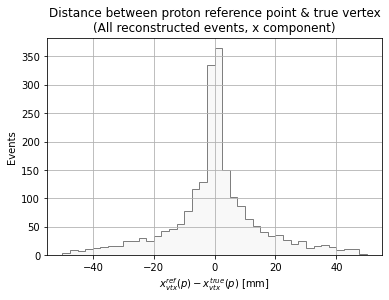

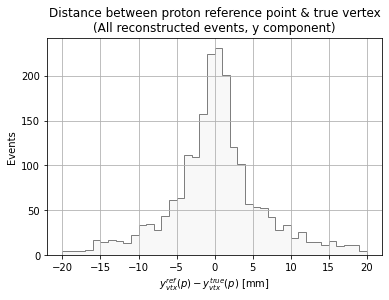

In [21]:
bias_boundary_dictionary = {
    'x': (-50,50),
    'y': (-20,20),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{ref}_{vtx}(p) - ' + comp + '^{true}_{vtx}(p)$ [mm]',
        'plot_title': 'Distance between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

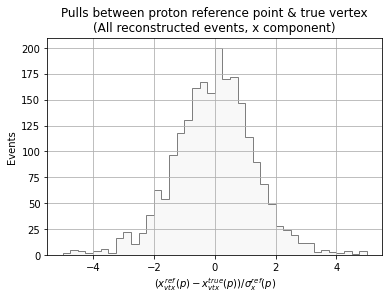

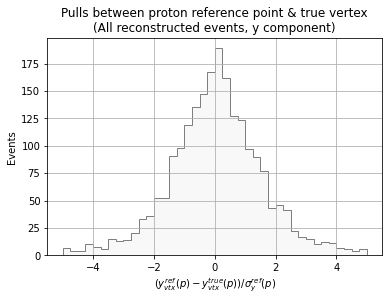

In [22]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'p_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{ref}_{vtx}(p) - ' + comp + '^{true}_{vtx}(p))/\sigma_' +  comp + '^{ref} (p)$',
        'plot_title': 'Pulls between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

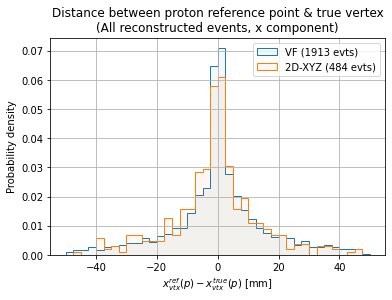

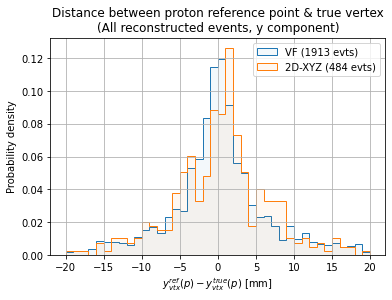

In [23]:
bias_boundary_dictionary = {
    'x': (-50,50),
    'y': (-20,20),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{ref}_{vtx}(p) - ' + comp + '^{true}_{vtx} (p)$ [mm]',
        'plot_title': 'Distance between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_2Dv3D_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

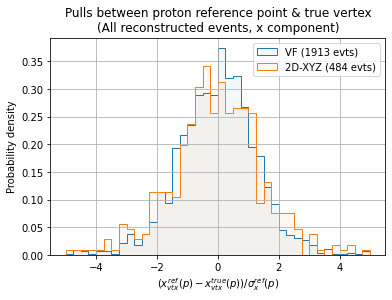

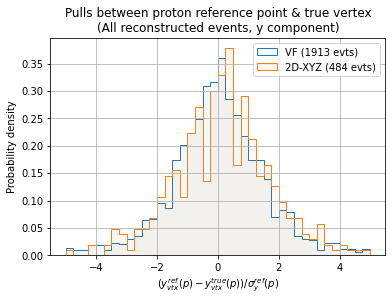

In [24]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'p_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{ref}_{vtx}(p) - ' + comp + '^{true}_{vtx}(p))/\sigma_' +  comp + '^{ref} (p)$',
        'plot_title': 'Pulls between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_2Dv3D_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

## Pion reference point

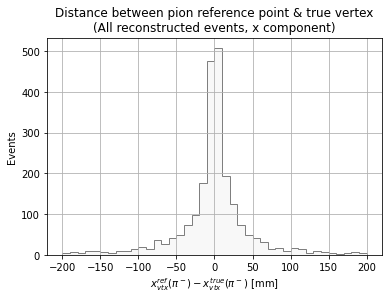

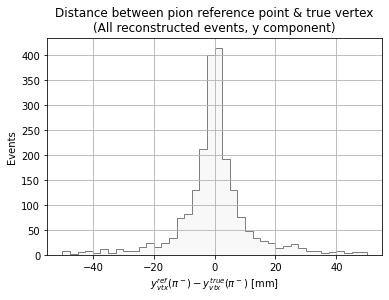

In [25]:
bias_boundary_dictionary = {
    'x': (-200,200),
    'y': (-50,50),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{ref}_{vtx}(\pi^-) - ' + comp + '^{true}_{vtx}(\pi^-)$ [mm]',
        'plot_title': 'Distance between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

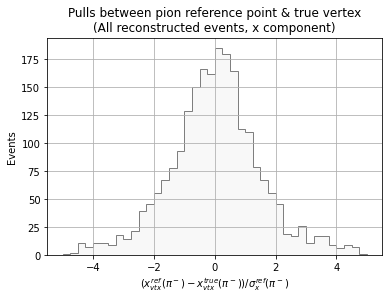

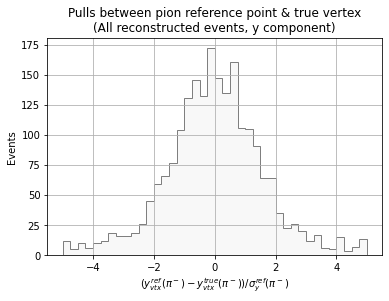

In [26]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'pim_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{ref}_{vtx}(\pi^-) - ' + comp + '^{true}_{vtx}(\pi^-))/\sigma_' +  comp + '^{ref} (\pi^-)$',
        'plot_title': 'Pulls between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

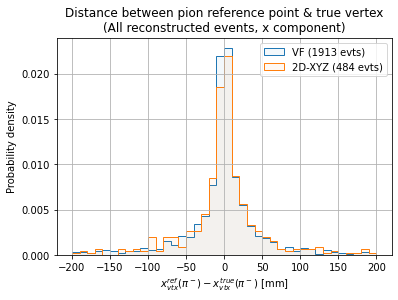

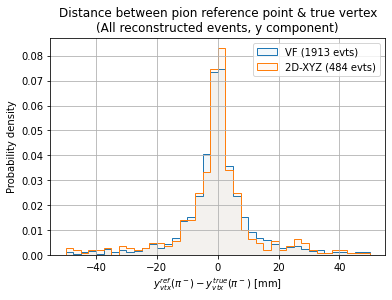

In [27]:
bias_boundary_dictionary = {
    'x': (-200,200),
    'y': (-50,50),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{ref}_{vtx}(\pi^-) - ' + comp + '^{true}_{vtx} (\pi^-)$ [mm]',
        'plot_title': 'Distance between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_2Dv3D_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

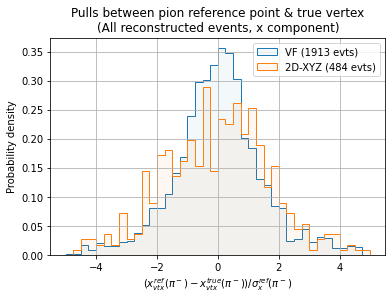

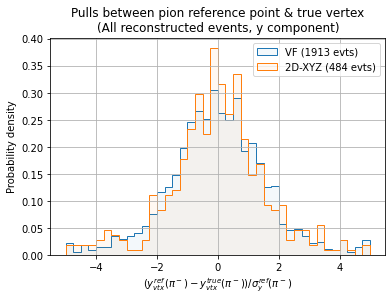

In [28]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'pim_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{ref}_{vtx}(\pi^-) - ' + comp + '^{true}_{vtx}(\pi^-))/\sigma_' +  comp + '^{ref} (\pi^-)$',
        'plot_title': 'Pulls between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_2Dv3D_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

## Proton momentum


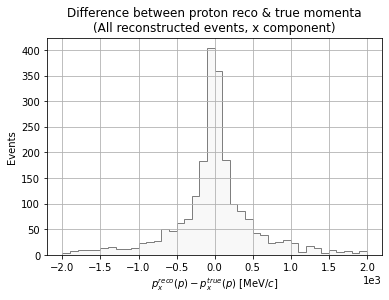

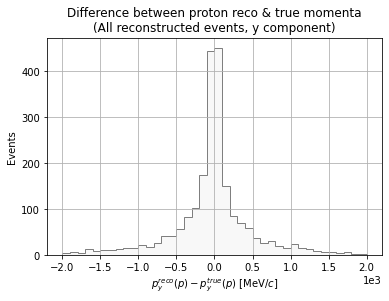

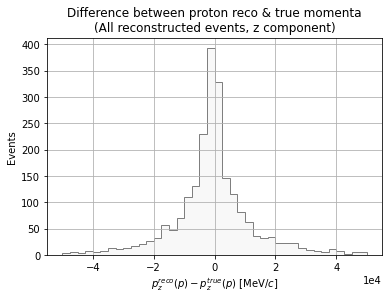

In [29]:
bias_boundary_dictionary = {
    'x': (-2e3,2e3),
    'y': (-2e3,2e3),
    'z': (-5e4,5e4)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()

    plot_args = {
        'axis_label': '$p^{reco}_' +  comp + '(p) - p^{true}_' +  comp + '(p)$ [MeV/$c$]',
        'plot_title': 'Difference between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

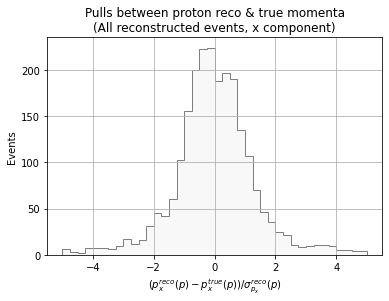

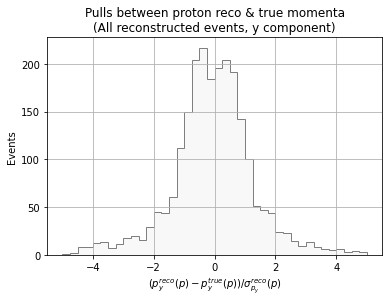

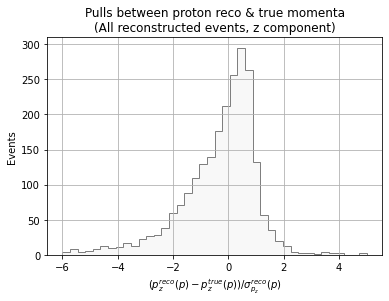

In [30]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()
    reco_error = 'p_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(p^{reco}_' +  comp + '(p) - p^{true}_' +  comp + '(p))/\sigma_{p_' +  comp + '}^{reco} (p)$',
        'plot_title': 'Pulls between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

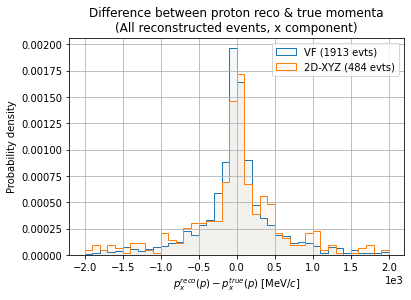

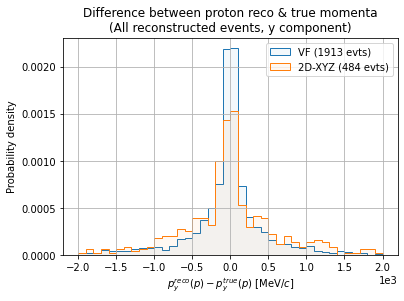

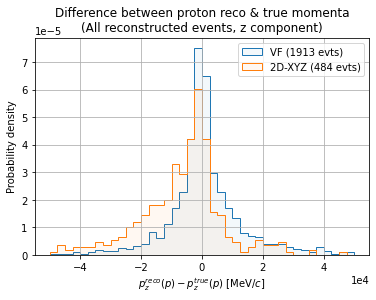

In [31]:
bias_boundary_dictionary = {
    'x': (-2e3,2e3),
    'y': (-2e3,2e3),
    'z': (-5e4,5e4)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()

    plot_args = {
        'axis_label': '$p^{reco}_' +  comp + '(p) - p^{true}_' +  comp + '(p)$ [MeV/$c$]',
        'plot_title': 'Difference between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_2Dv3D_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

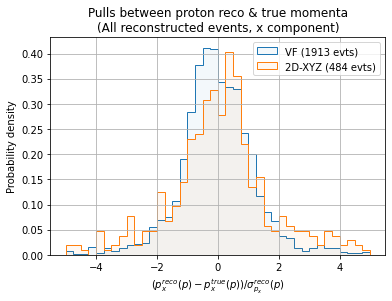

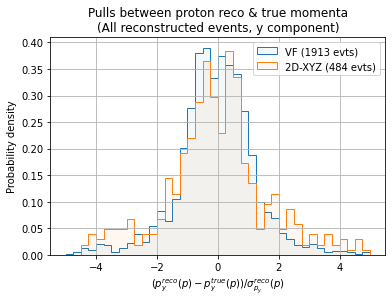

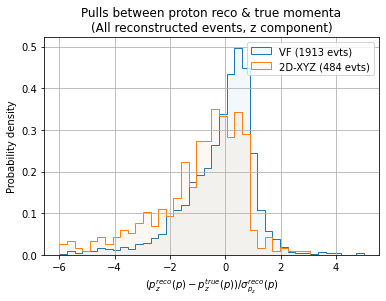

In [32]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()
    reco_error = 'p_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(p^{reco}_' +  comp + '(p) - p^{true}_' +  comp + '(p))/\sigma_{p_' +  comp + '}^{reco} (p)$',
        'plot_title': 'Pulls between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_2Dv3D_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

## Pion momentum

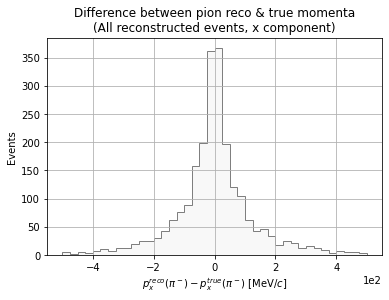

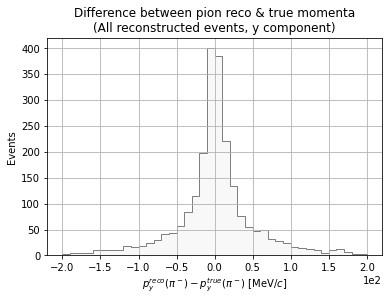

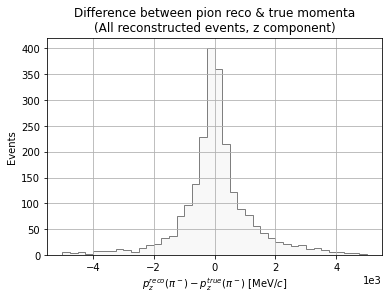

In [33]:
bias_boundary_dictionary = {
    'x': (-5e2,5e2),
    'y': (-2e2,2e2),
    'z': (-5e3,5e3)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()

    plot_args = {
        'axis_label': '$p^{reco}_' +  comp + '(\pi^-) - p^{true}_' +  comp + '(\pi^-)$ [MeV/$c$]',
        'plot_title': 'Difference between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

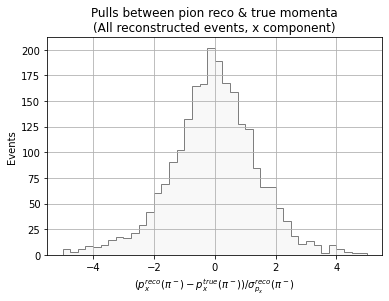

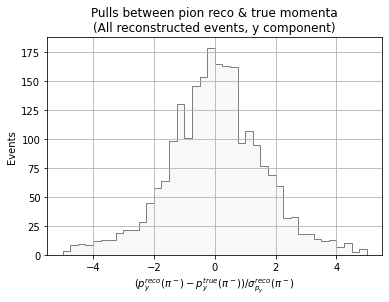

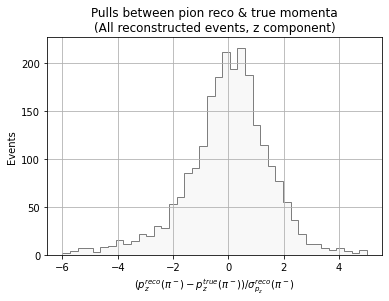

In [34]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()
    reco_error = 'pim_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(p^{reco}_' +  comp + '(\pi^-) - p^{true}_' +  comp + '(\pi^-))/\sigma_{p_' +  comp + '}^{reco} (\pi^-)$',
        'plot_title': 'Pulls between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

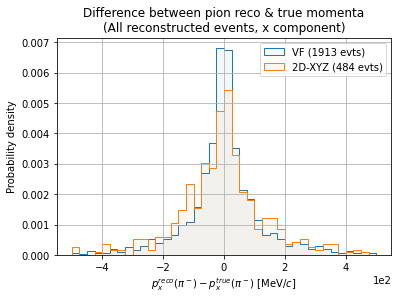

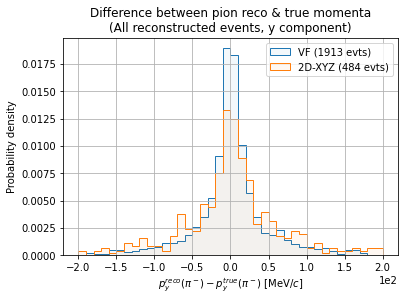

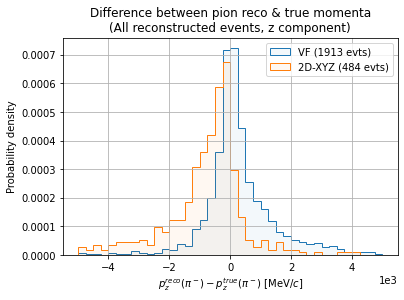

In [35]:
bias_boundary_dictionary = {
    'x': (-5e2,5e2),
    'y': (-2e2,2e2),
    'z': (-5e3,5e3)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()

    plot_args = {
        'axis_label': '$p^{reco}_' +  comp + '(\pi^-) - p^{true}_' +  comp + '(\pi^-)$ [MeV/$c$]',
        'plot_title': 'Difference between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_2Dv3D_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

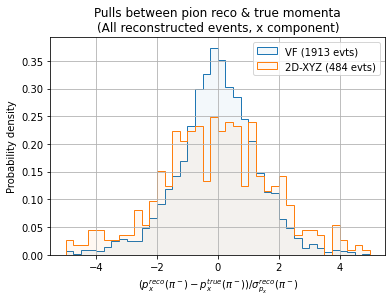

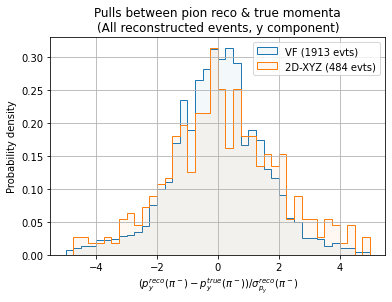

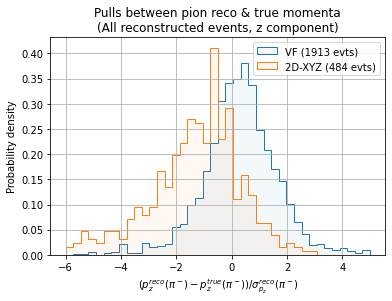

In [36]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()
    reco_error = 'pim_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(p^{reco}_' +  comp + '(\pi^-) - p^{true}_' +  comp + '(\pi^-))/\sigma_{p_' +  comp + '}^{reco} (\pi^-)$',
        'plot_title': 'Pulls between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_2Dv3D_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)